In [1]:
import uproot
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Open LHE file
with uproot.open("partons.root:events") as f:
    #print(f.keys())
    px = f['px'].array()
    py = f['py'].array()
    pz = f['pz'].array()
    e = f['energy'].array()
    m = f['mass'].array()
    pid = f['pid'].array()
    m1 = f['mother1'].array()
    m2 = f['mother2'].array()

# Extract top quark 3-Vector based on PID
mask = pid==6
top_px = px[mask]
top_py = py[mask]
top_pz = pz[mask]

counts = ak.num(px)
mask = counts==11
print("Hard Processes with 11 Partons:  ", len(counts[mask]), " / ", len(px))

Hard Processes with 11 Partons:   1695  /  100000


In [3]:
# Open Delphes file
with uproot.open("dataset.root:Delphes") as f:
    #print(f.keys())
    jet_pt = f['ParticleFlowJet15/ParticleFlowJet15.PT'].array()
    jet_eta = f['ParticleFlowJet15/ParticleFlowJet15.Eta'].array()
    jet_phi = f['ParticleFlowJet15/ParticleFlowJet15.Phi'].array()

In [9]:
# Initialize lists for plotting
pt_partons = []
pt_fat_jets = []
deltaR = []
deltaEta = []
deltaPhi = []

# Loop over all events
for i in range(len(jet_pt)):
    
    if i%100==0:
        print("\tProcessing: ", i, " / ", len(jet_pt), end="\r")
    
    # Ensure only one top quark
    assert len(top_px[i])==1
    
    # Ensure at least one fat jet
    if len(jet_pt[i])<1:
        continue
        
    # Save parton 3-Vector
    parton = vector.MomentumObject3D(px=top_px[i][0], py=top_py[i][0], pz=top_pz[i][0])
    
    # Find closest fat jet in deltaR
    delR = []
    for j in range(len(jet_pt[i])):
        delR.append(parton.deltaR(vector.MomentumObject3D(pt=jet_pt[i][j], eta=jet_eta[i][j], phi=jet_phi[i][j])))
    argmin = np.argmin(delR)
    
    candidate = vector.MomentumObject3D(pt=jet_pt[i][argmin], eta=jet_eta[i][argmin], phi=jet_phi[i][argmin])
    if abs(parton.deltaphi(candidate))>2:
        continue
    if abs(parton.deltaeta(candidate))>2:
        continue
    
    # Closest jet in deltaR to parton is matched jet
    matched_jet = candidate
    
    # Fill lists for plotting
    pt_partons.append(parton.pt)
    pt_fat_jets.append(matched_jet.pt)
    deltaR.append(parton.deltaR(matched_jet))
    deltaEta.append(parton.deltaeta(matched_jet))
    deltaPhi.append(parton.deltaphi(matched_jet))
print("\tProcessing: ", len(jet_pt), " / ", len(jet_pt), end="\r")

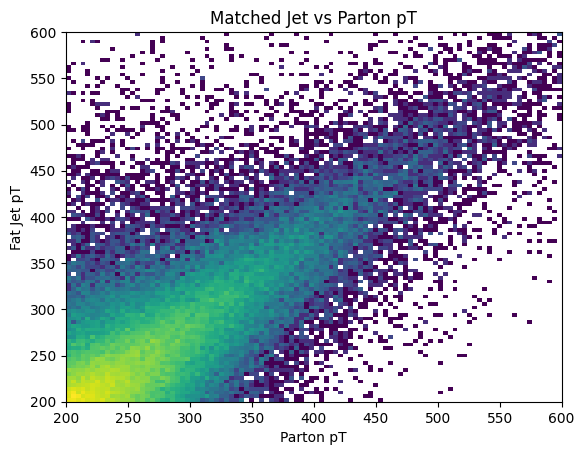

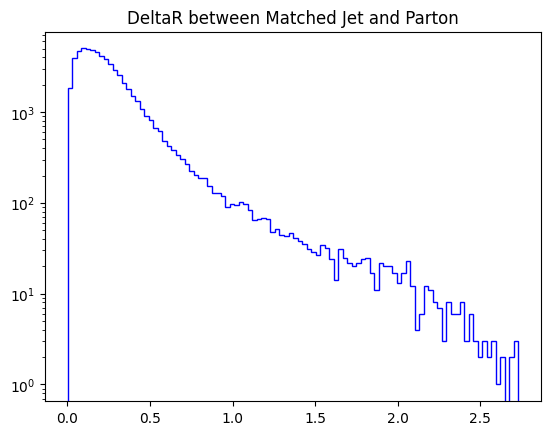

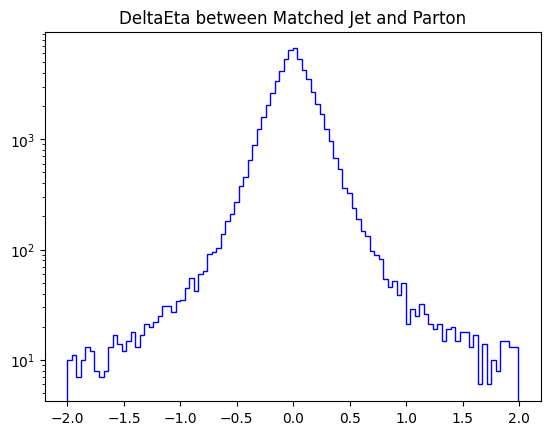

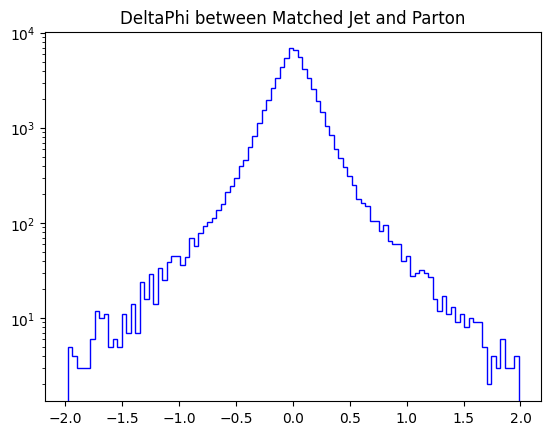

In [10]:
plt.title("Matched Jet vs Parton pT")
plt.hist2d(pt_partons,pt_fat_jets, bins=100,norm=mcolors.LogNorm(),range=((200,600),(200,600)))
plt.xlabel("Parton pT")
plt.ylabel("Fat Jet pT")
plt.show()

plt.title("DeltaR between Matched Jet and Parton")
plt.hist(deltaR,histtype='step',bins=100,color='b')
plt.yscale("log")
plt.show()

plt.title("DeltaEta between Matched Jet and Parton")
plt.hist(deltaEta,histtype='step',bins=100,color='b')
plt.yscale("log")
plt.show()

plt.title("DeltaPhi between Matched Jet and Parton")
plt.hist(deltaPhi,histtype='step',bins=100,color='b')
plt.yscale("log")
plt.show()